In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from copy import deepcopy as copy
from scipy import optimize
import torch
np.random.seed(1)
torch.random.manual_seed(1)

import sys
sys.path.append('../')  #for savo import
sys.path.append('../../machineIO/')  #for machineIO import
from savo import savo
from savo.model import GaussianProcess as GP
from savo.optim import adam
from machineIO.util import plot_2D_projection, dictClass
from machineIO.objFunc import SingleTaskObjectiveFunction
from machineIO.VM import VirtualMachineIO
from machineIO import Evaluator

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
ndim = 50
budget = 200
model_train_budget = 200
ninit = ndim  # number of initial ES steps to collect data for surrogate model training
noise = 1e-3
max_dx = 2e-2
lr = 1
asynchronous = True

In [4]:
control_CSETs = [f'X{i}:I_CSET' for i in range(ndim)]
control_RDs   = [f'X{i}:I_RD'   for i in range(ndim)]
control_min   = -np.ones(ndim)
control_max   =  np.ones(ndim)
control_maxstep = max_dx*np.ones(ndim)
control_tols  = 1e-3*(control_max-control_min)
monitor_RDs   = [f'Y{i}:I_RD' for i in range(2)]
monitor_min   = -2*np.ones(2)
monitor_max   =  2*np.ones(2)

objective_PVs = monitor_RDs
composite_objective_name = 'rastrigin'

In [5]:
vmio = VirtualMachineIO(
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min,
    control_max = control_max,
    monitor_min = monitor_min,
    monitor_max = monitor_max,
    fetch_data_time_span = 1.0
)

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [6]:
def rastrigin(x, noise=0.0):
    x = torch.as_tensor(x)
    d = x.shape[-1]
    y = torch.sum(x**2 - torch.cos(2*np.pi*x), dim=-1) / d + 1
    return 1 - y + torch.randn_like(y) * noise

In [7]:
# random initial point far from optimum
y = 1
while y>0:
    control_init = np.random.rand(ndim)*(control_max-control_min)+control_min
    vmio.x = control_init
    ret, df = vmio.get_df(monitor_RDs)
    y = rastrigin(df.values).mean()

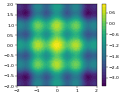

In [8]:
grid = np.linspace(-2,2,128)
x1,x2 = np.meshgrid(grid,grid)
xgrid = np.vstack((x1.flatten(), x2.flatten())).T
ygrid = rastrigin(xgrid,noise=0)
def plot_contour(fig,ax):
    cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=32)
    fig.colorbar(cs,ax=ax)
fig,ax = plt.subplots(figsize=(4,3.3),dpi=32)
plot_contour(fig,ax)

In [9]:
obj_func = SingleTaskObjectiveFunction(
    objective_PVs = monitor_RDs,
    composite_objective_name = composite_objective_name,
    custom_function = rastrigin,
    objective_goal = None, 
    objective_weight = None,
    objective_tolerance = None,
)

In [10]:
evaluator = Evaluator(
    machineIO = vmio,
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    control_tols = control_tols,
    monitor_RDs = monitor_RDs,
    df_manipulators = [obj_func.calculate_objectives_from_df],
)

In [11]:
def plot_grad(sv,epoch,evaluator=evaluator,arrow_length_factor=5):
    train_x = torch.tensor(np.array(sv.history['x'   ][:epoch]),dtype=torch.float64)
    train_y = torch.tensor(np.array(sv.history['y'   ][:epoch]),dtype=torch.float64).view(-1,1)
    test_x = train_x[-sv.n_grad_ave:].clone()
    test_x[:-1] = 0.5*(test_x[:-1] + test_x[-1,:].view(1,-1))
    test_y = train_y[-sv.n_grad_ave:]
    sv.train_model(train_x,train_y)
    dydx_batched = sv.model.get_grad(test_x)
    eval_hist_mean = evaluator.get_history()['mean']
    z_train = eval_hist_mean[['Y0:I_RD','Y1:I_RD']].values[:epoch]
    z  = []
    zp = []
    for x, y, dydx in zip(test_x,test_y,dydx_batched):
        df1 = evaluator.submit(x.detach().numpy())
        df1,_ = evaluator.get_result(df1)
        df2 = evaluator.submit(x + dydx*arrow_length_factor*sv.lr/(1+np.exp((y))))
        df2,_ = evaluator.get_result(df2)
        z.append( df1[['Y0:I_RD','Y1:I_RD']].mean().values)
        zp.append(df2[['Y0:I_RD','Y1:I_RD']].mean().values- z[-1])
    z = np.array(z)
    zp= np.array(zp)

    n_grad_ave = sv.n_grad_ave
    x_min, x_max = z[:, 0].min(), z[:, 0].max()
    y_min, y_max = z[:, 1].min(), z[:, 1].max()
    x_padding = (x_max - x_min) * 1
    y_padding = (y_max - y_min) * 1
    zoom_xlim = (x_min - x_padding, x_max + x_padding)
    zoom_ylim = (y_min - y_padding, y_max + y_padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4.5), dpi=150)
    current_point = z[-1]
    
    # --- Left Plot: Full Data ---
    plot_contour(fig, ax[0])
    ax[0].set_title("Objective in latent space")
    ax[0].scatter(z_train[:, 0], z_train[:, 1], s=2, c='black', alpha=0.7, label='Training Data')
    ax[0].plot(current_point[0], current_point[1], 'rx', markersize=5, label='Current Set Point')
    
    # Add a dashed rectangle using the new dynamically calculated limits
    rect = patches.Rectangle(
        (zoom_xlim[0], zoom_ylim[0]),
        zoom_xlim[1] - zoom_xlim[0],
        zoom_ylim[1] - zoom_ylim[0],
        linewidth=1.5,
        edgecolor='blue',
        alpha = 0.5,
        facecolor='none',
        linestyle='--',
        label='Zoom Area'
    )
    ax[0].add_patch(rect)
    ax[0].set_xlim(-0.55, 0.15)
    ax[0].set_ylim(-0.1, 0.6)
    ax[0].set_xlabel("Parameter 1")
    ax[0].set_ylabel("Parameter 2")
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.5)
    
    # --- Right Plot: Zoomed-in View with Gradients ---
    plot_contour(fig, ax[1])
    ax[1].scatter(z_train[:, 0], z_train[:, 1], s=4, c='black', alpha=0.7, label='trianing data')
    ax[1].quiver(
        z[:, 0], z[:, 1],
        zp[:, 0], zp[:, 1],
        color='red',
        angles='xy',
        scale_units='xy',
        scale=5,
        width=0.005,
        label='Estimated Gradients (dy/dx)'
    )
    
    ax[1].plot(current_point[0], current_point[1], 'rx', markersize=4, label='currrent set point')
    ax[1].set_xlim(zoom_xlim)
    ax[1].set_ylim(zoom_ylim)
    ax[1].set_xlabel("Parameter 1")
    ax[1].set_ylabel("Parameter 2")
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.5)
    
    # Adjust layout and display the plot
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
def plot_hist(history,eval_hist_mean):
    fig, ax = plt.subplots(1,4,figsize=(15,3),dpi=128)
    xaxis = np.arange(len(history['y']))
    ax[0].plot(xaxis, history['y'])
    ax[0].set_xlabel('epoch');
    ax[0].set_ylabel('objective');
    ax[1].plot(xaxis, history['cpu_time'])
    ax[1].set_xlabel('epoch');
    ax[1].set_ylabel('cpu_time');
    if 'model_fit_time' in history:
        ax[2].plot(history['model_fit_time']);
        ax[2].set_xlabel('epoch');
        ax[2].set_ylabel('model training time');
    fig.tight_layout()
    
    plot_contour(fig,ax[3])
    ax[3].plot(eval_hist_mean['Y0:I_RD'],eval_hist_mean['Y1:I_RD'],'k',lw=1)
    start_x = eval_hist_mean['Y0:I_RD'][0]
    start_y = eval_hist_mean['Y1:I_RD'][0]
    end_x = eval_hist_mean['Y0:I_RD'][-1]
    end_y = eval_hist_mean['Y1:I_RD'][-1]
    ax[3].plot(start_x, start_y, 'g+', markersize=4, label='Start Point') # 'go' for green circle
    ax[3].plot(end_x, end_y, 'r*', markersize=4, label='End Point') # 'rs' for red square
    ax[3].set_xlabel('Y0:I_RD')
    ax[3].set_ylabel('Y1:I_RD')
    ax[3].set_title('Latent Objetive Path')
    ax[3].legend() # Show the labels
    fig.tight_layout()

# ES

In [13]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator,
          asynchronous = asynchronous)
for i in range(budget):
    sv.step(lr=0,lrES=1)

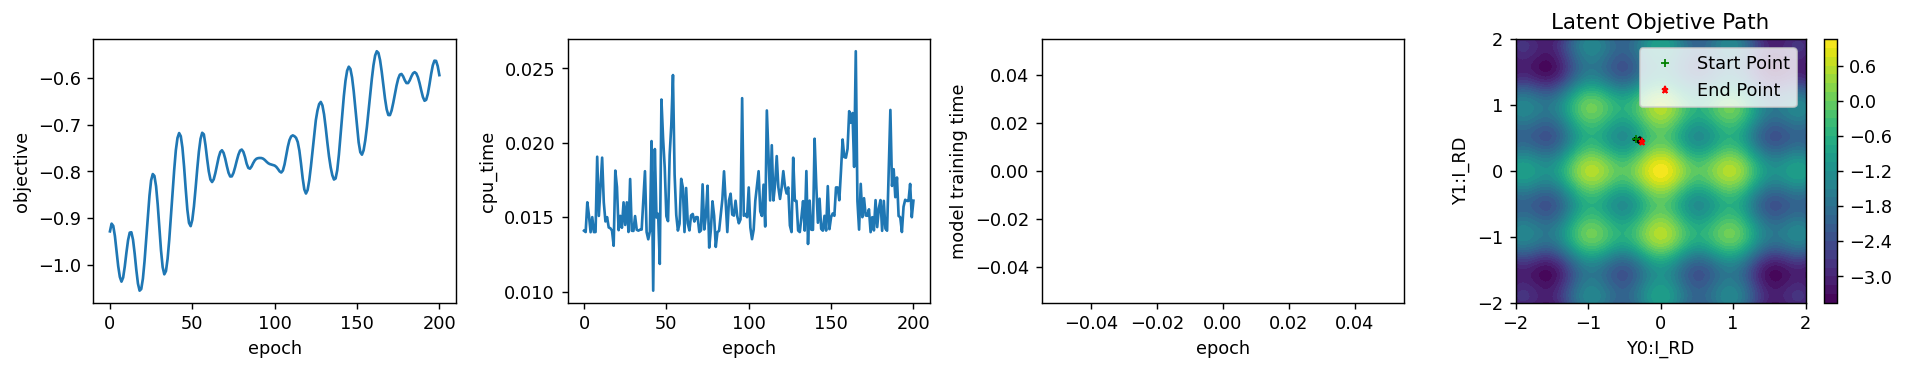

In [14]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

# ES + adamSG

In [15]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, optimizer=optimizer, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)

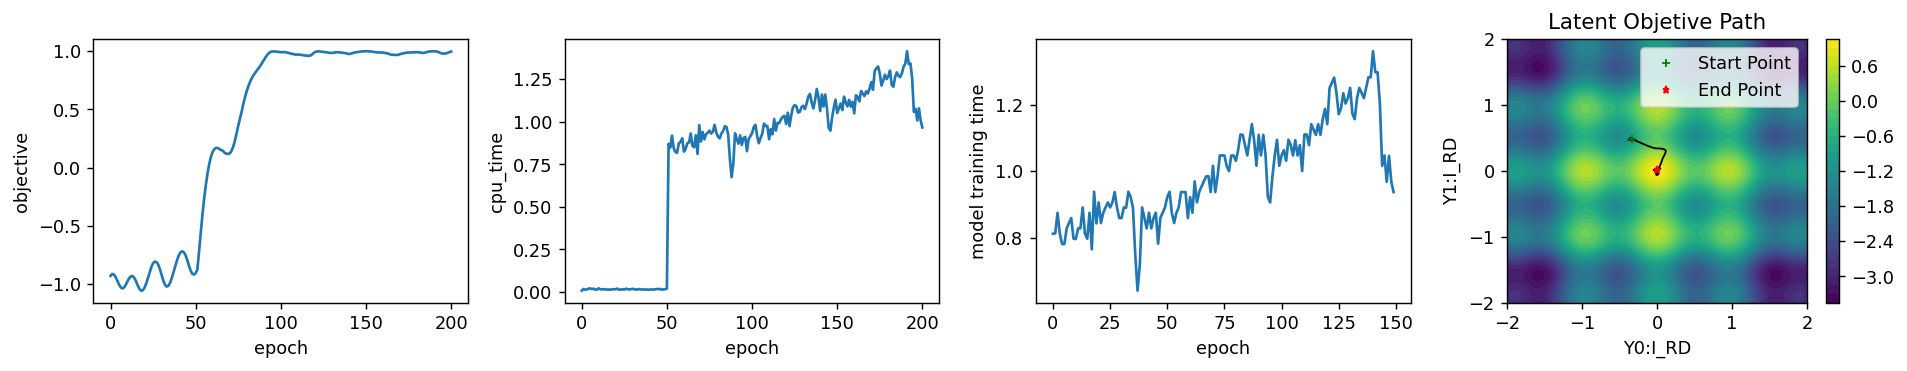

In [16]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

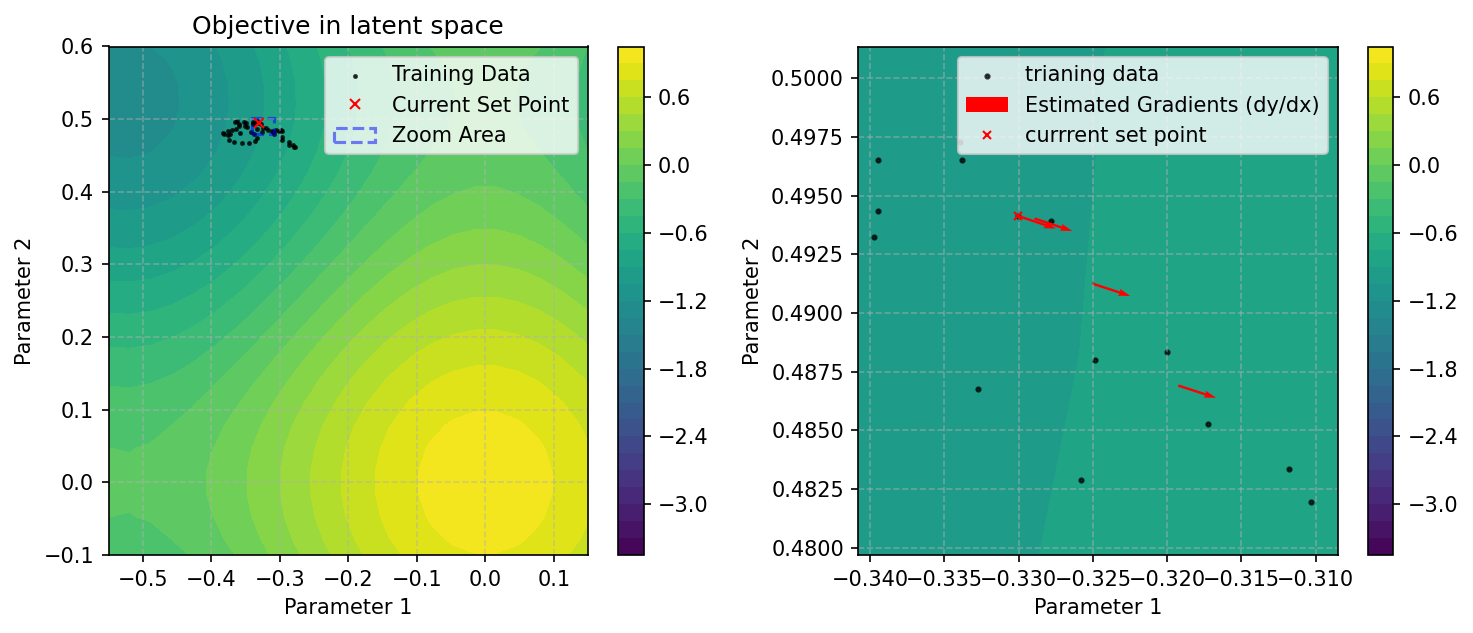

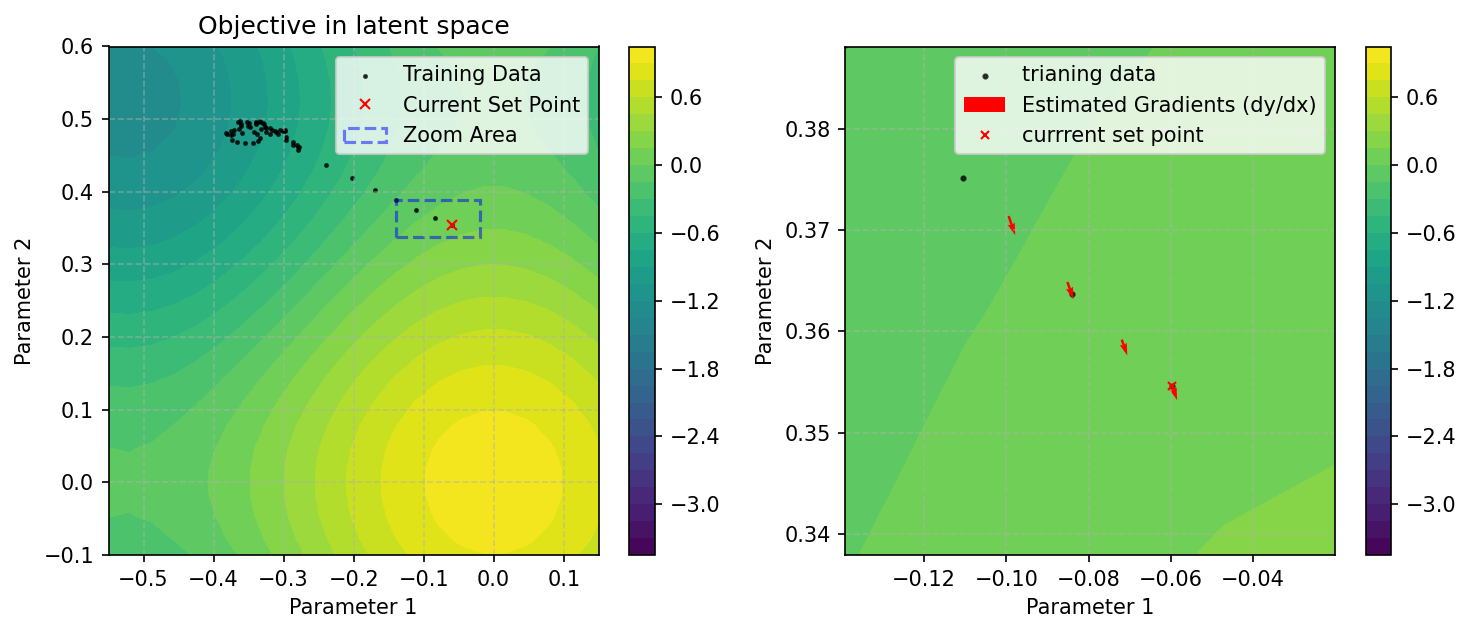

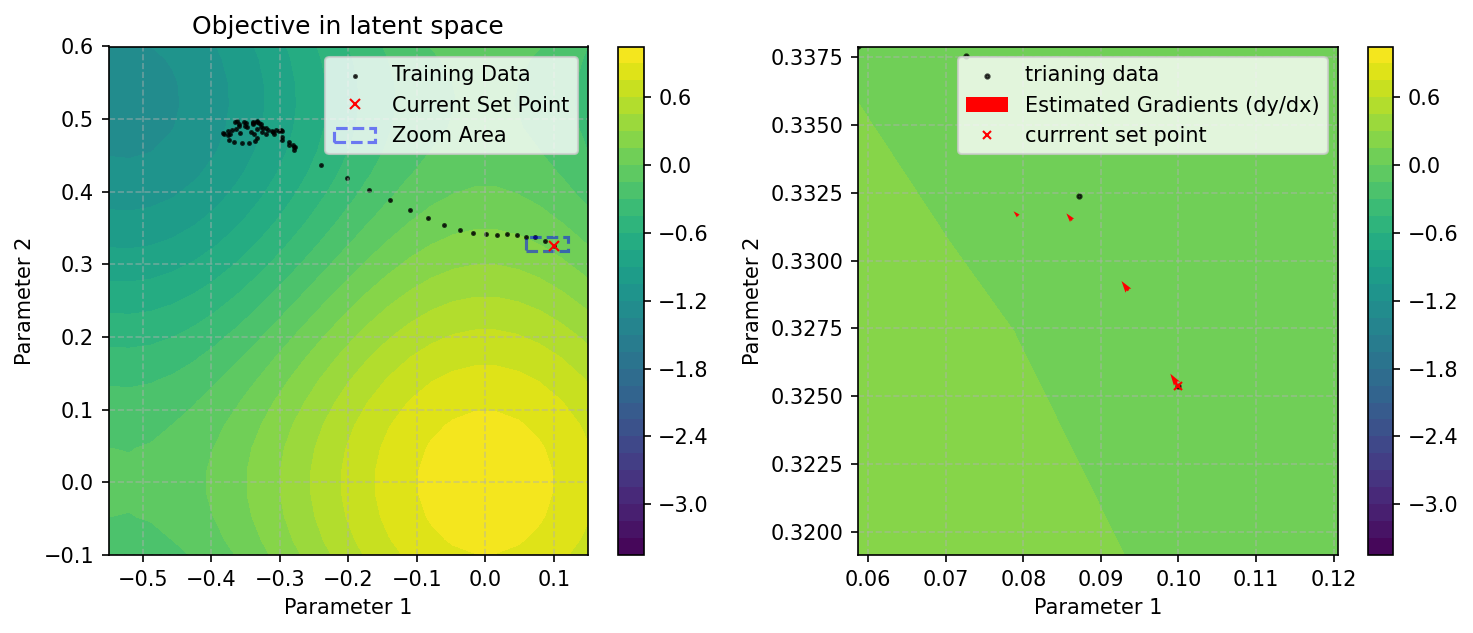

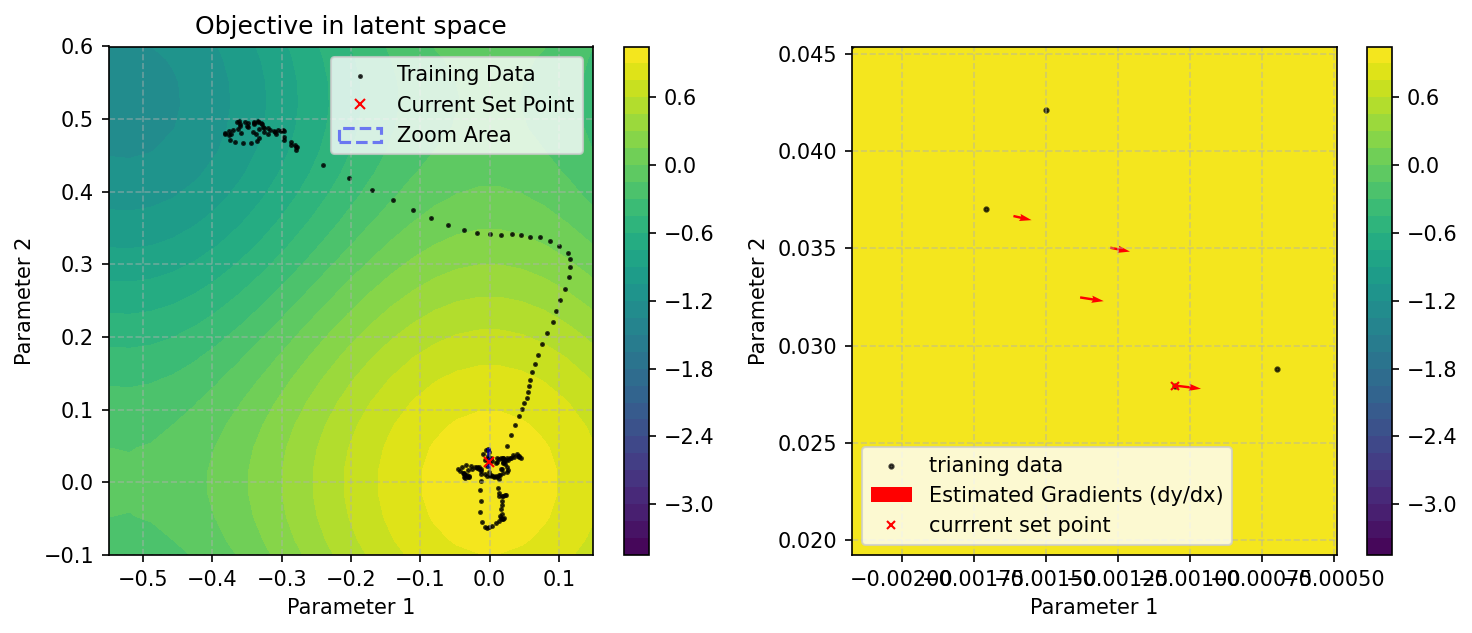

In [17]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# ES + SG

In [18]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)

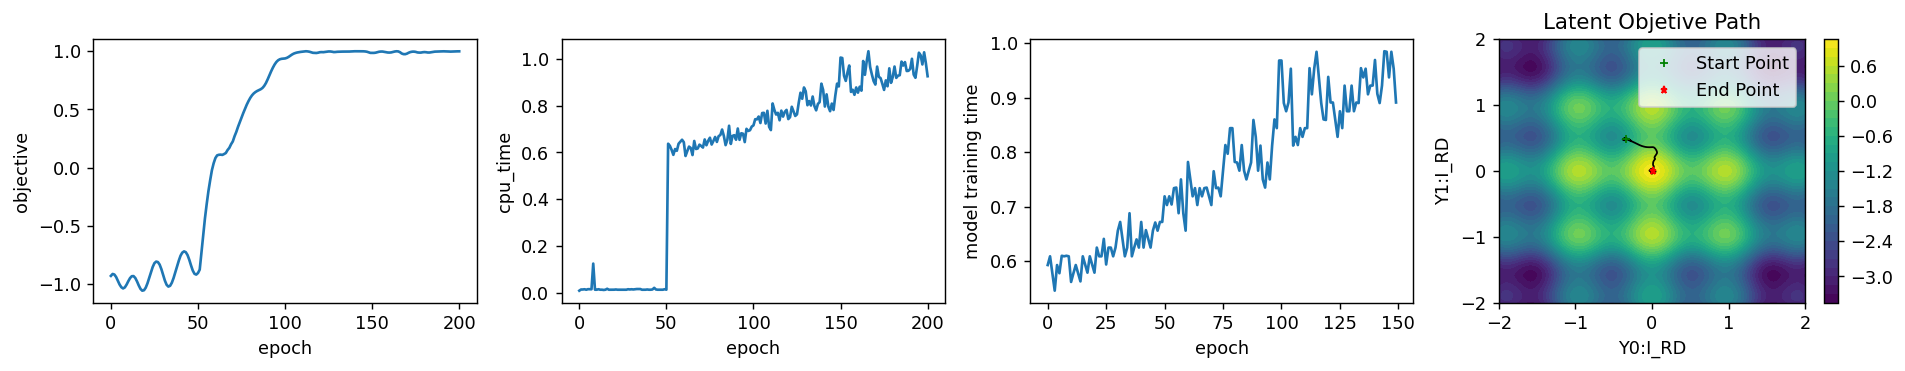

In [19]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

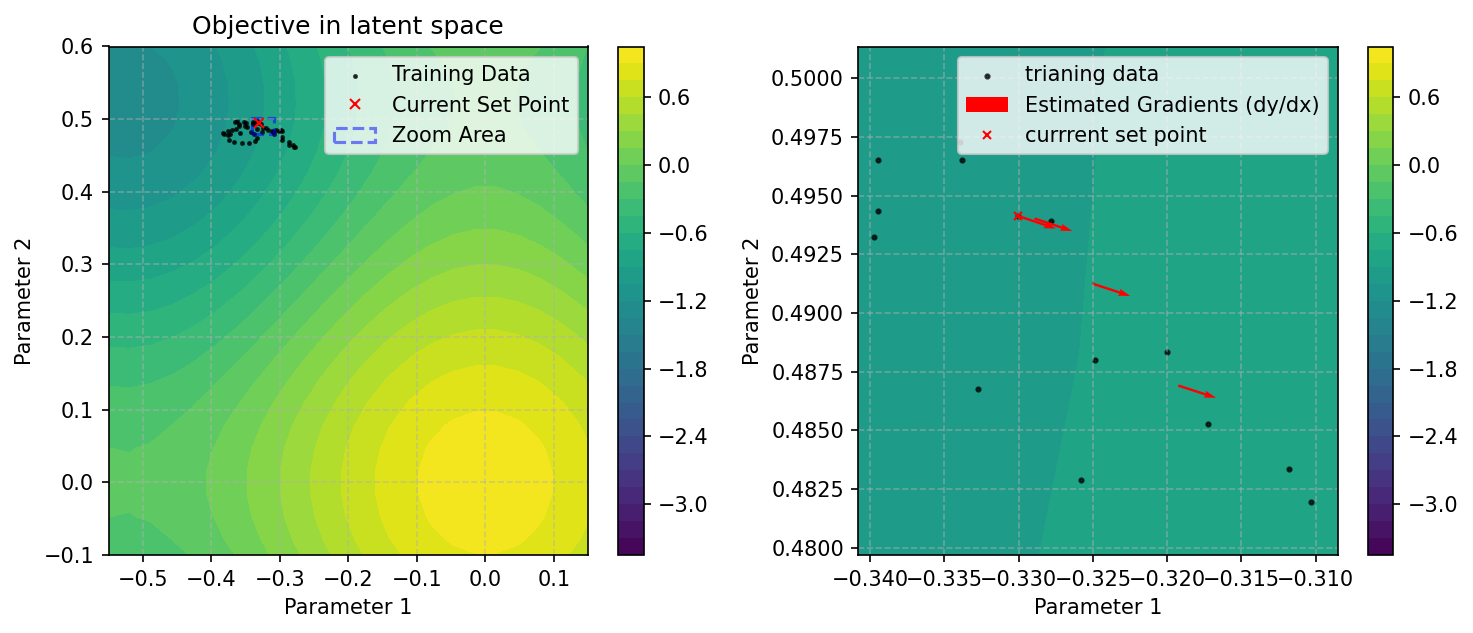

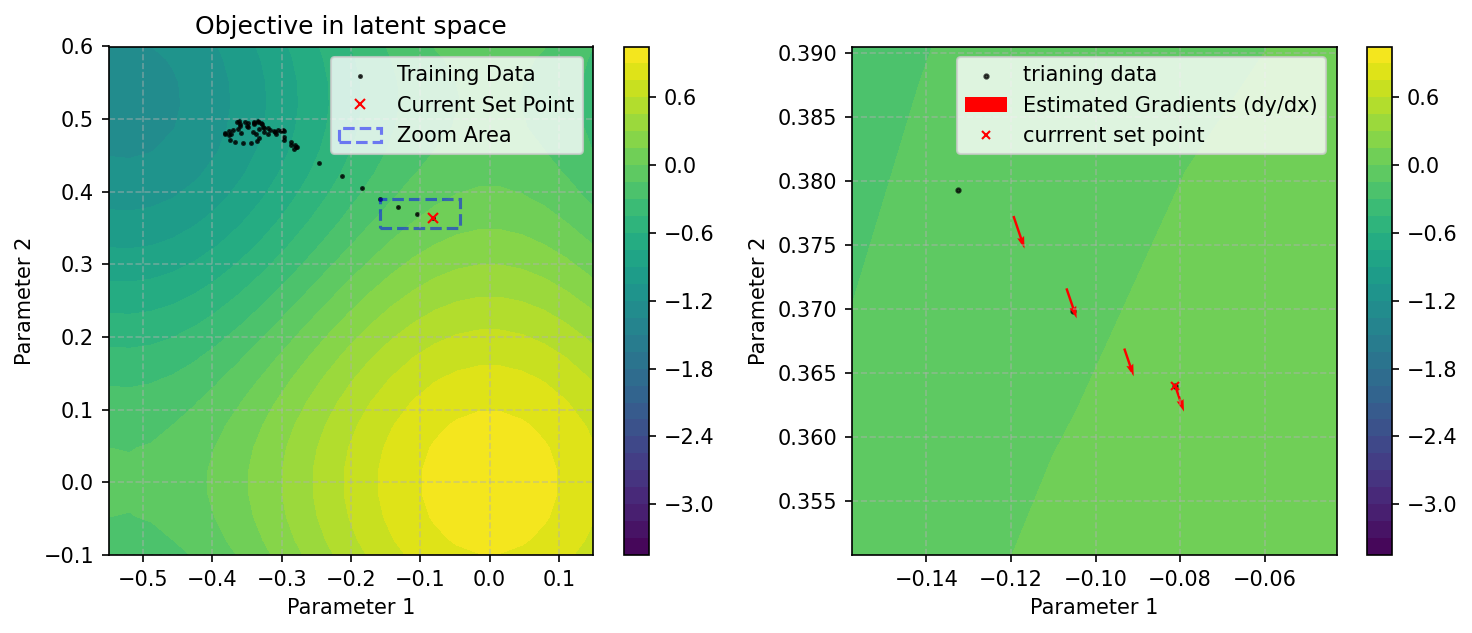

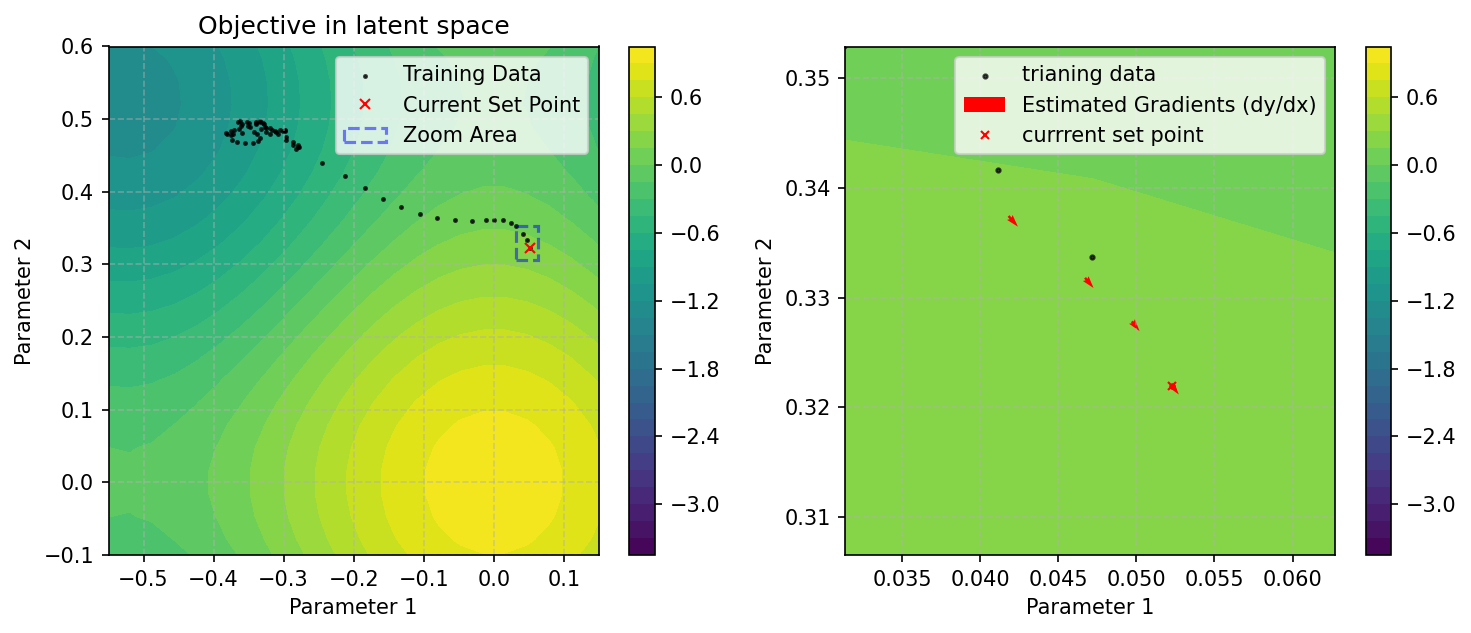

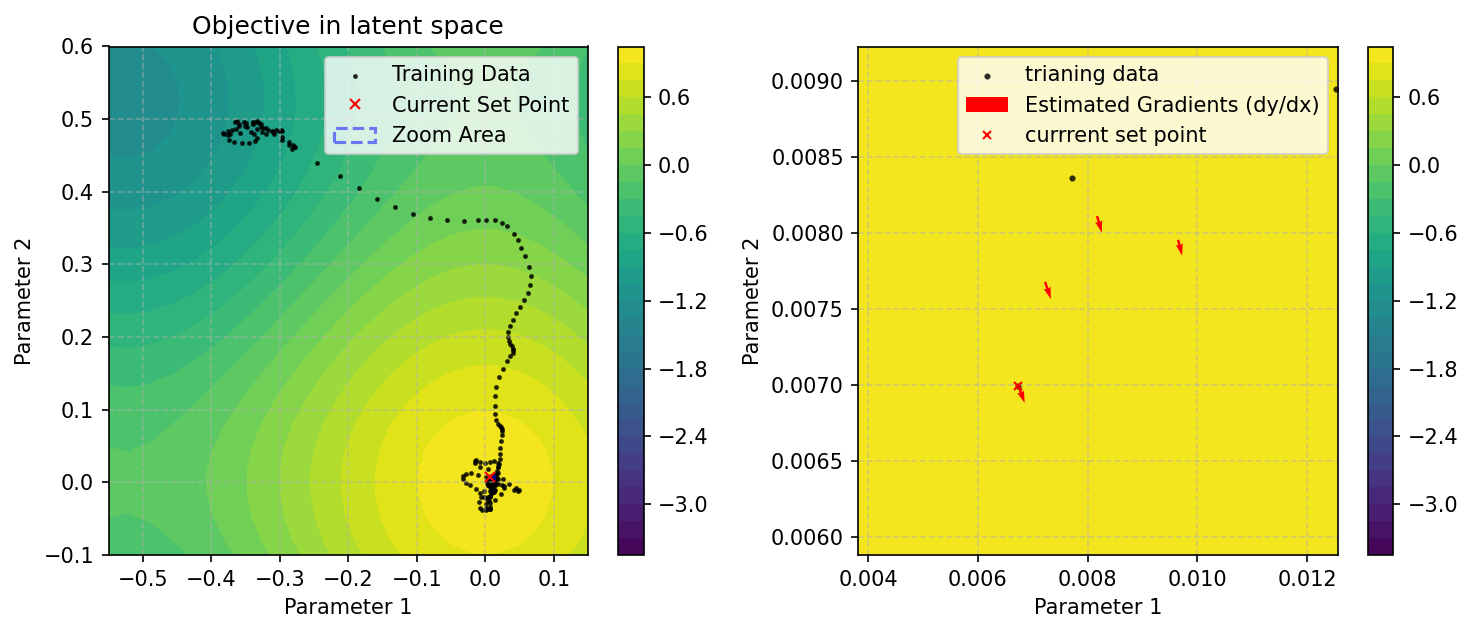

In [20]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# ES + SG normalized grad

In [21]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1,normalize_gradient_step=True)

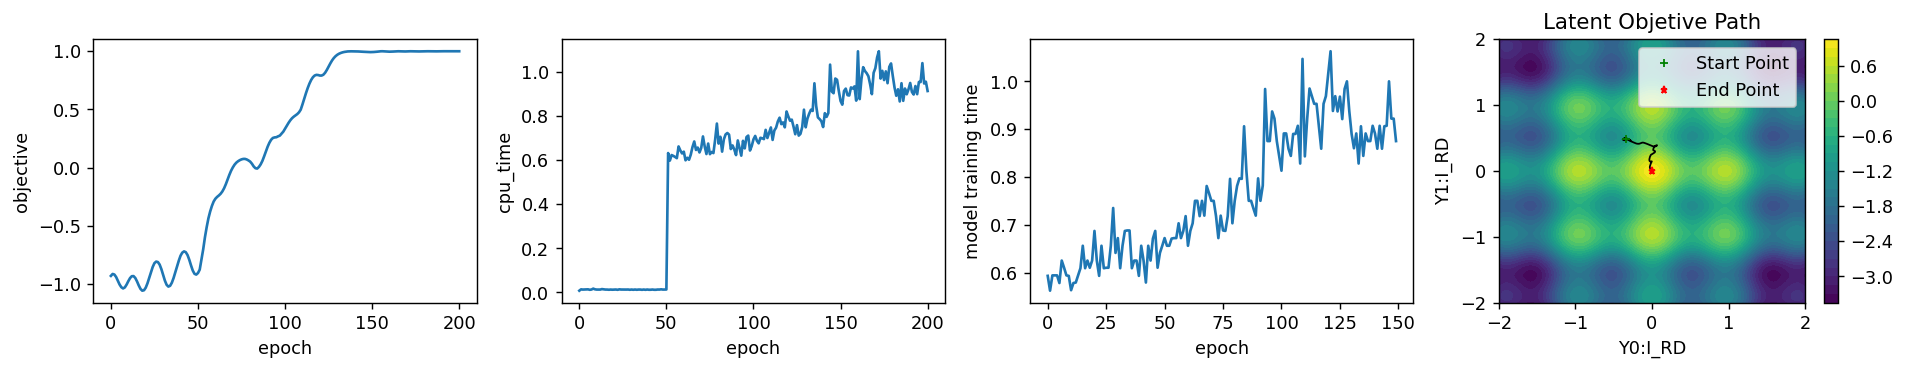

In [22]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

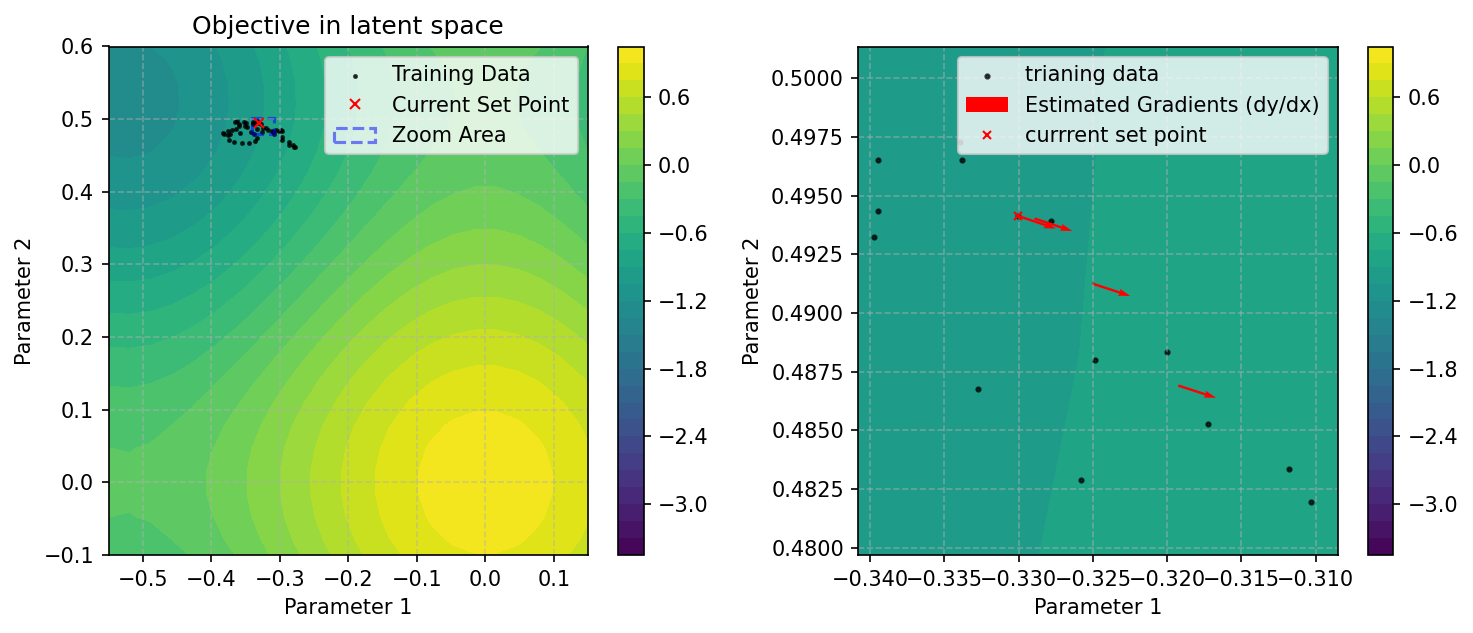

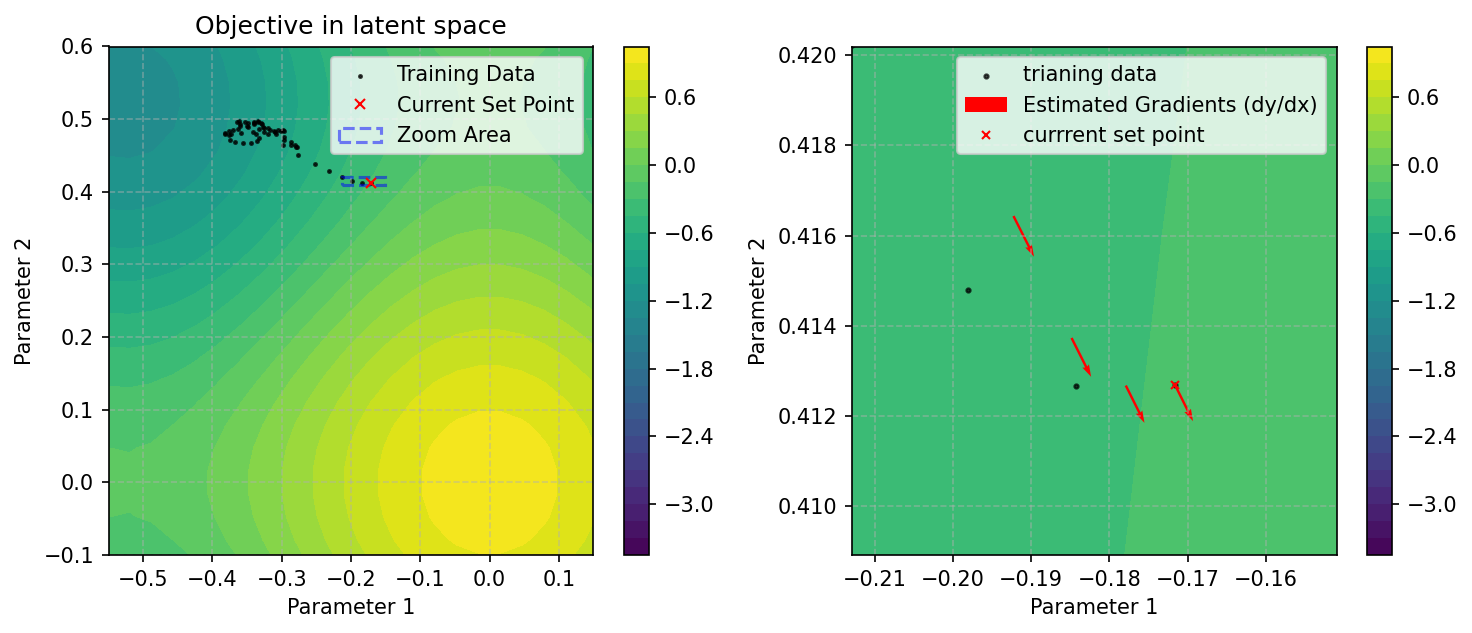

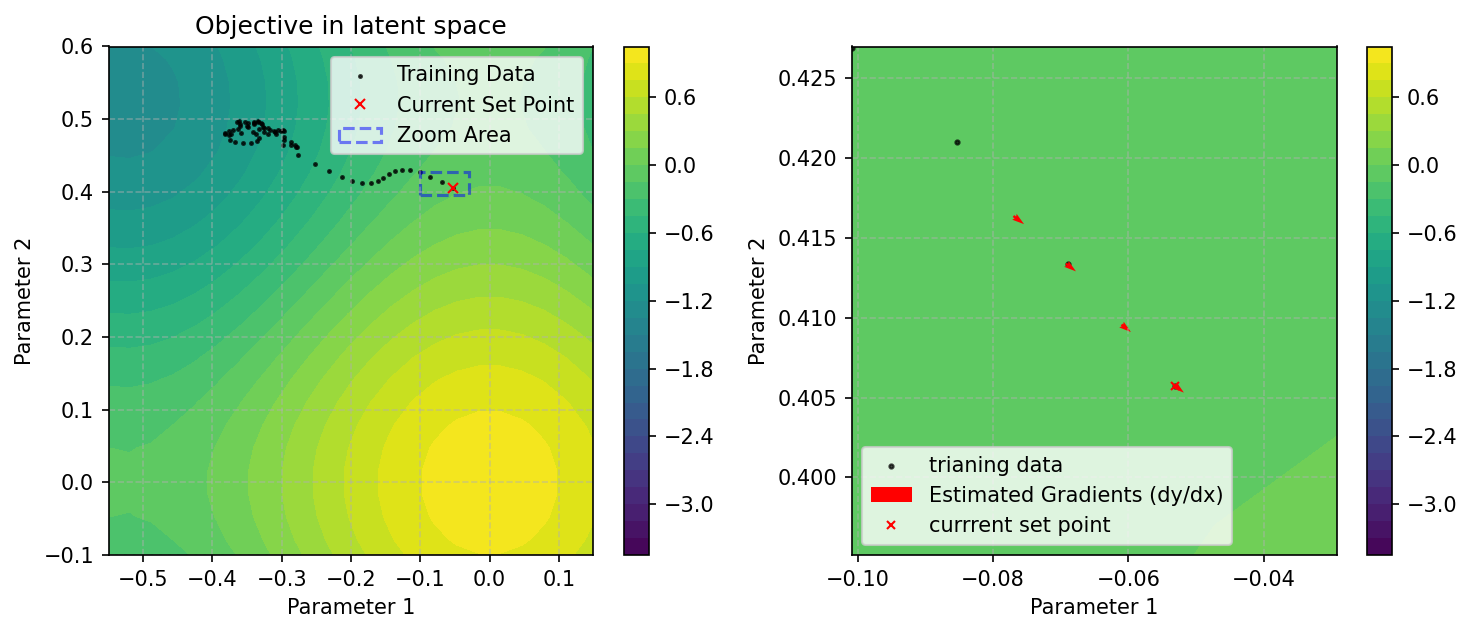

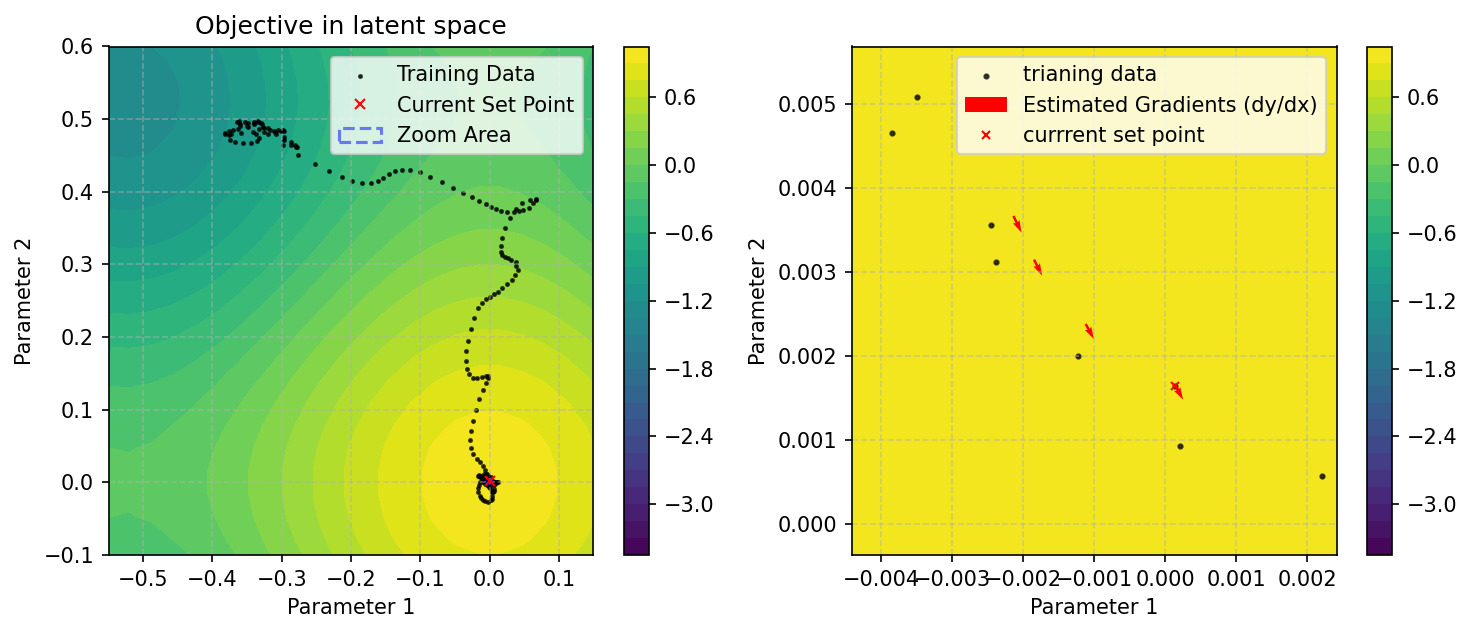

In [23]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# ES + SG penalize_uncertain_gradient

In [24]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1,penalize_uncertain_gradient=True)

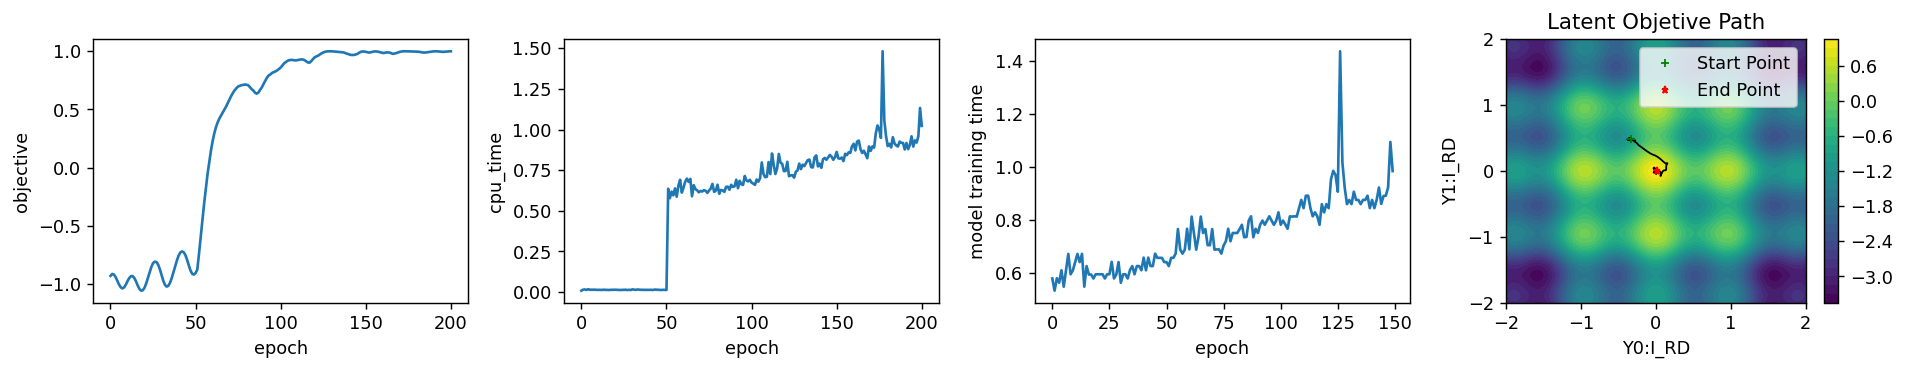

In [25]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

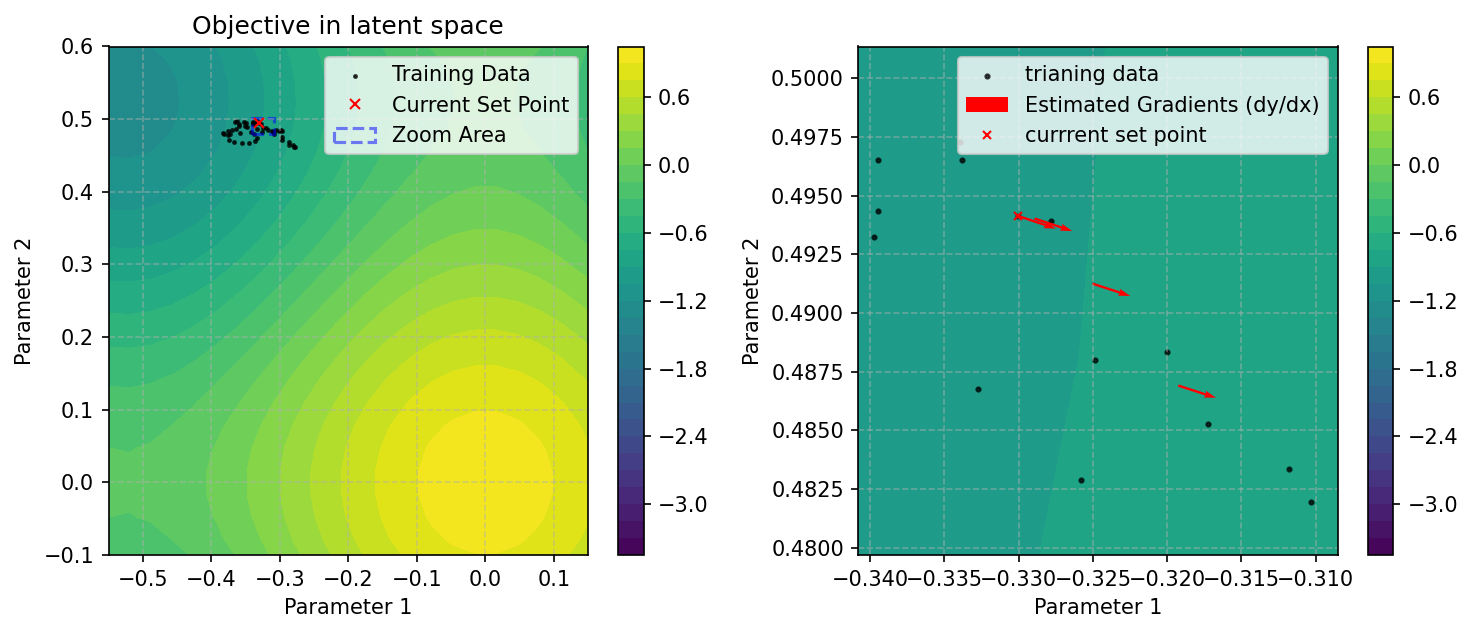

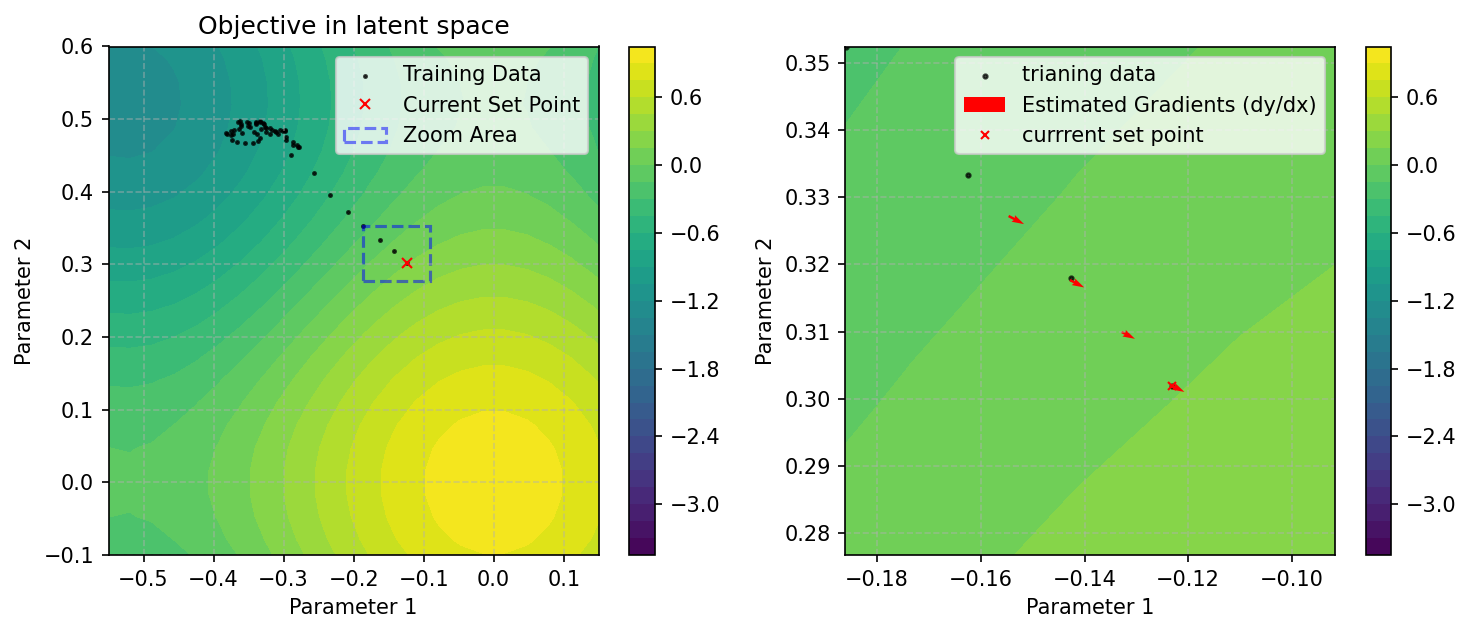

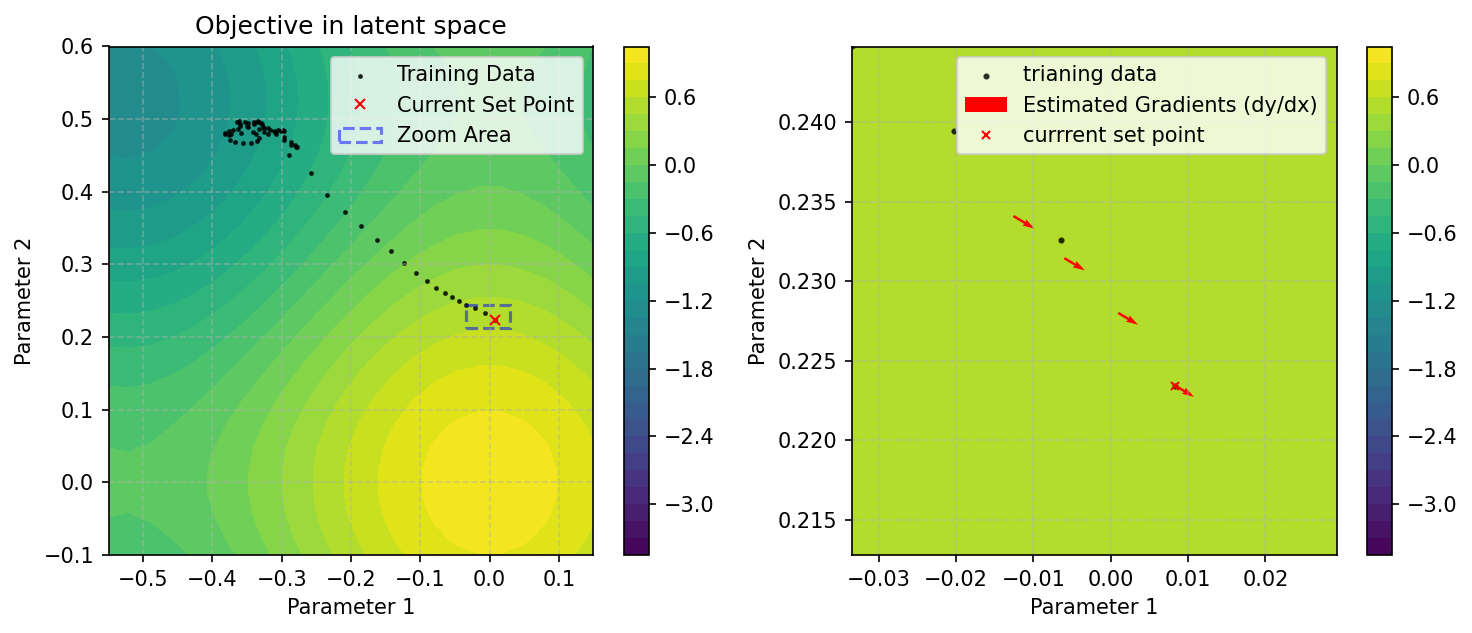

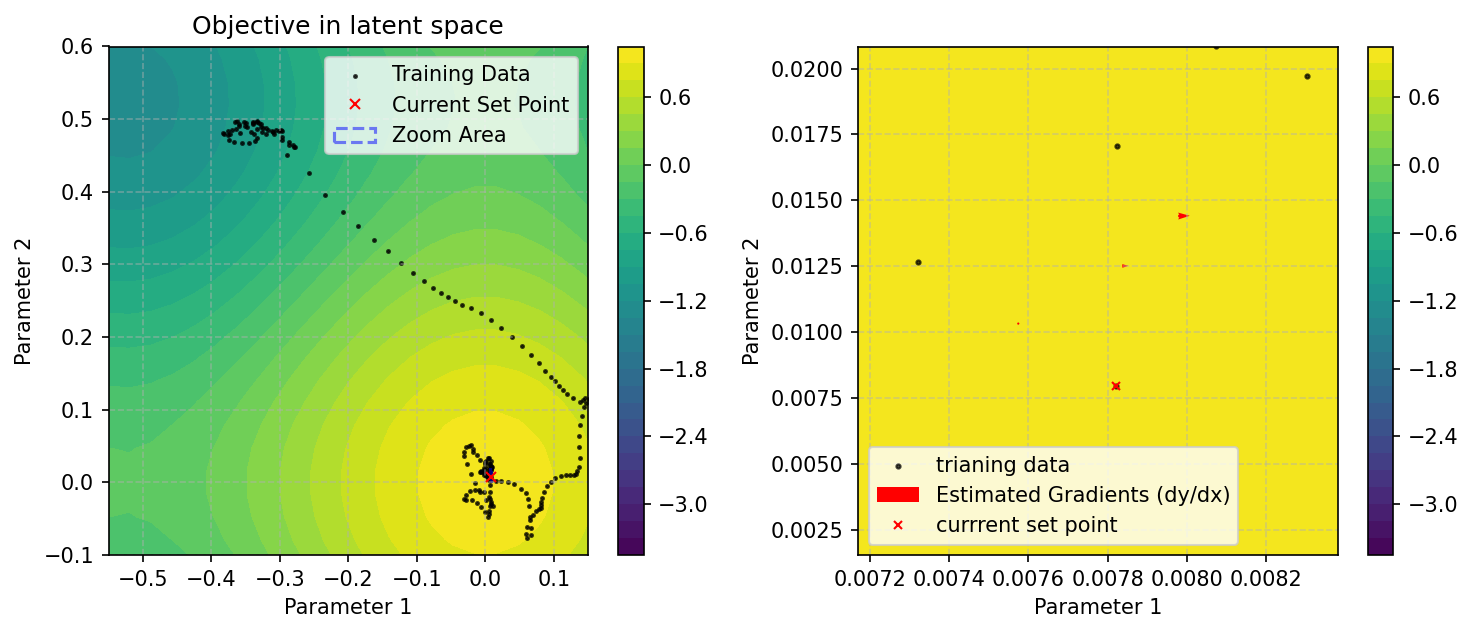

In [26]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# ES + adamSG penalize_uncertain_gradient

In [27]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget,optimizer = adam(), asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1,penalize_uncertain_gradient=True)

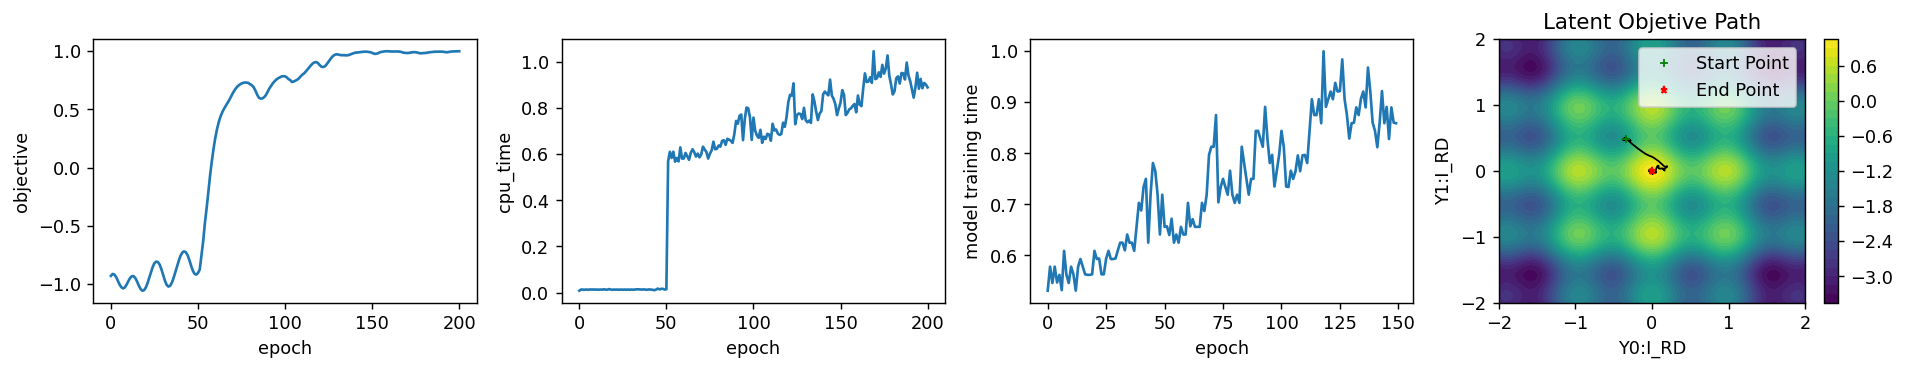

In [28]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

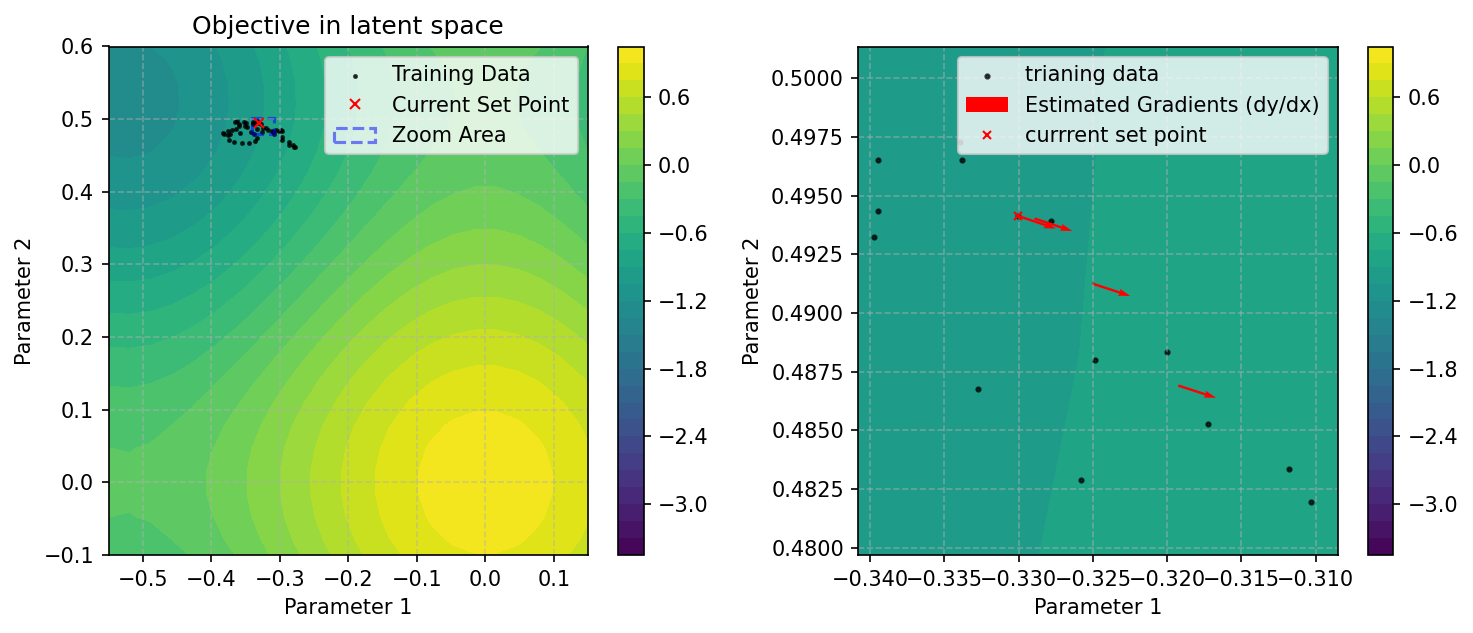

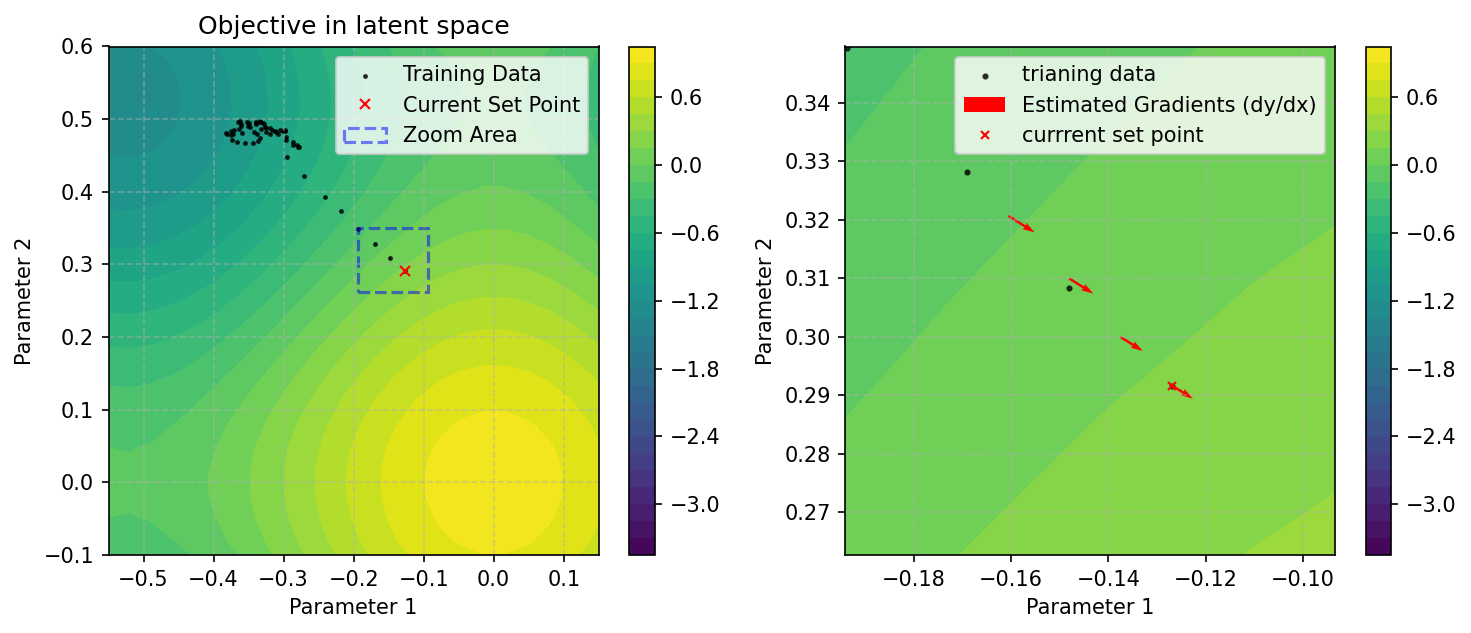

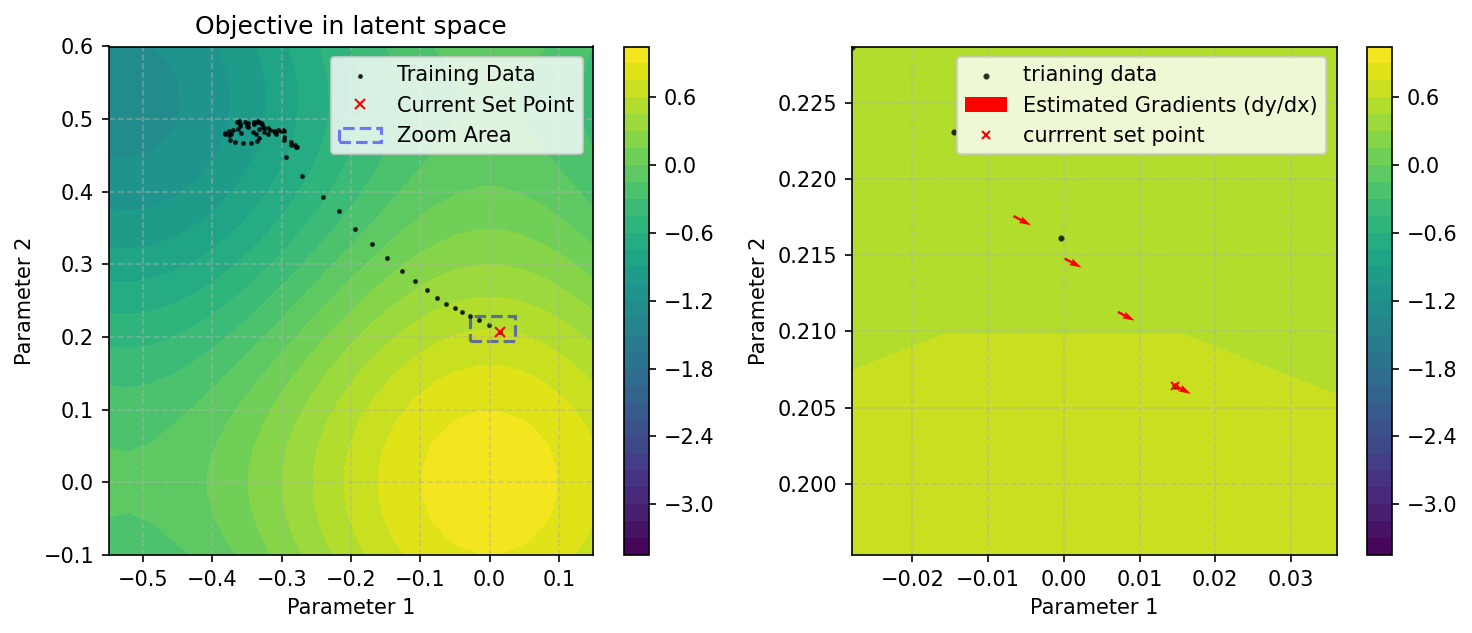

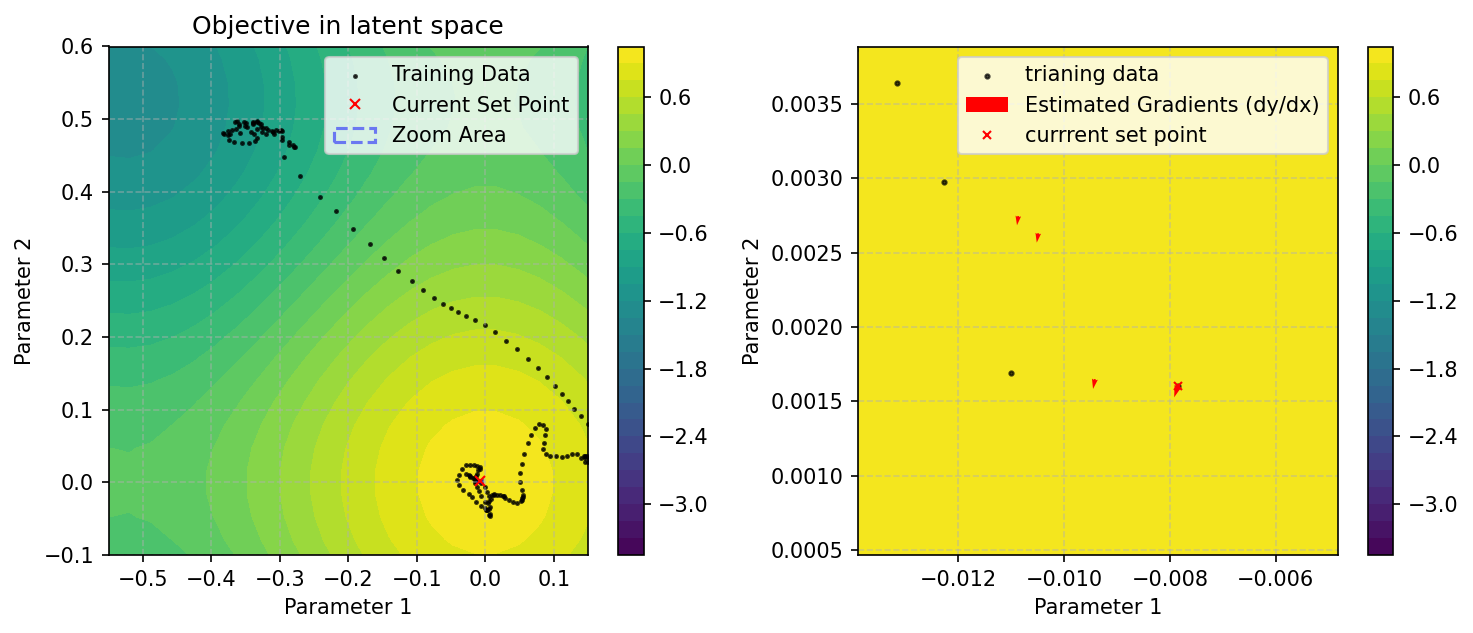

In [29]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# SG wo ES

In [30]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=0)

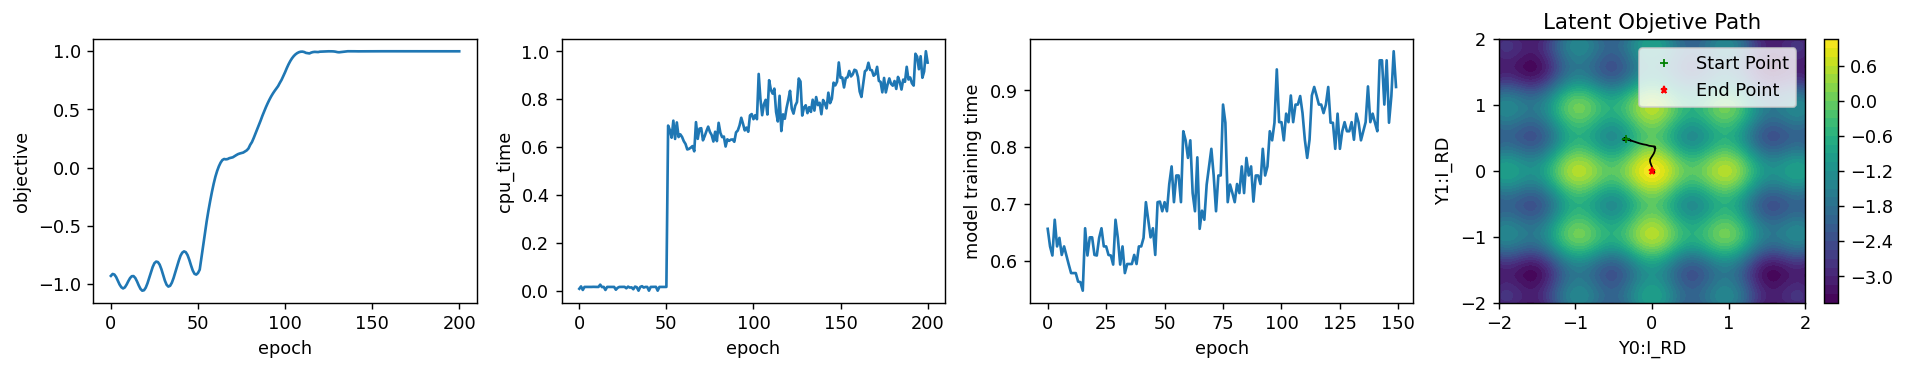

In [31]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

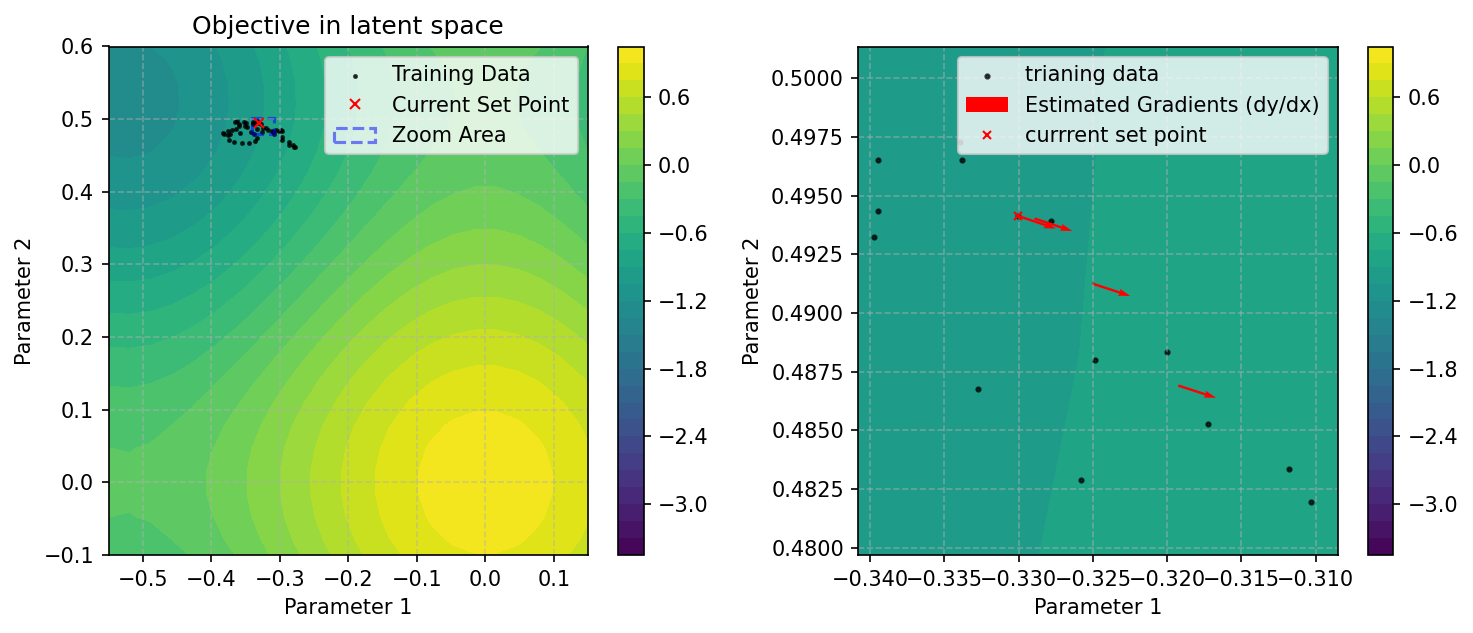

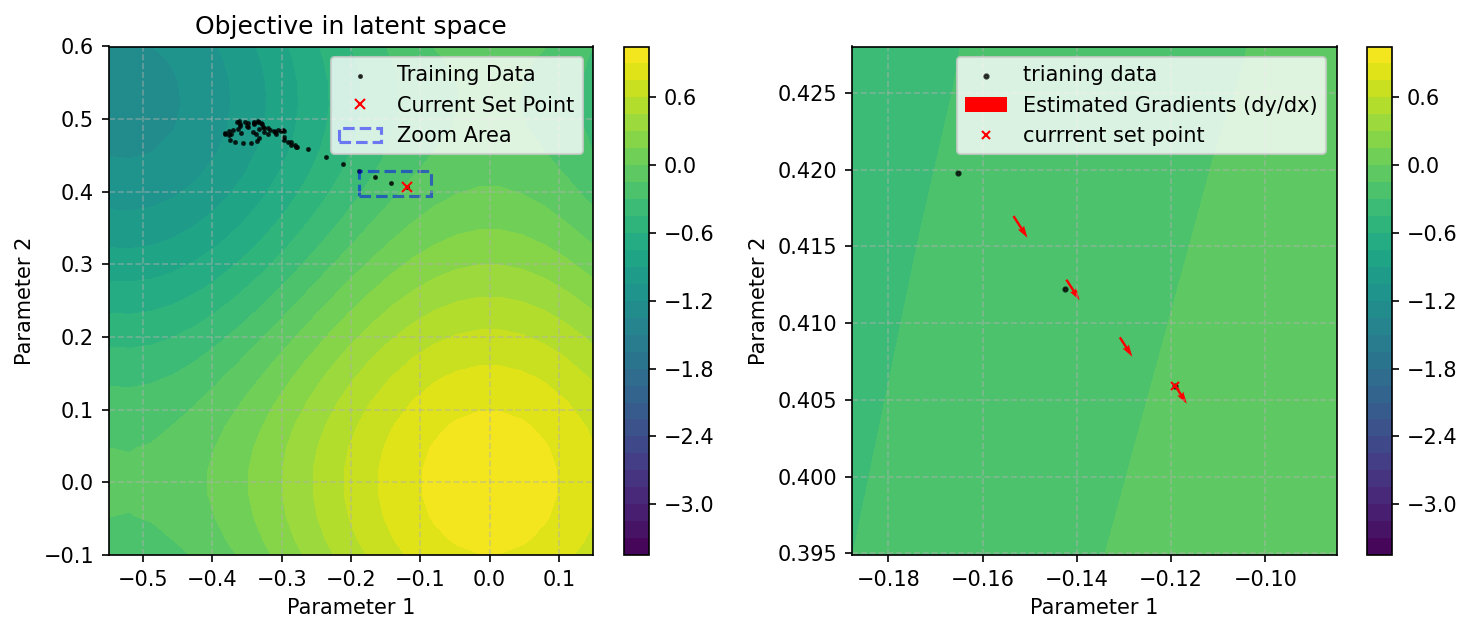

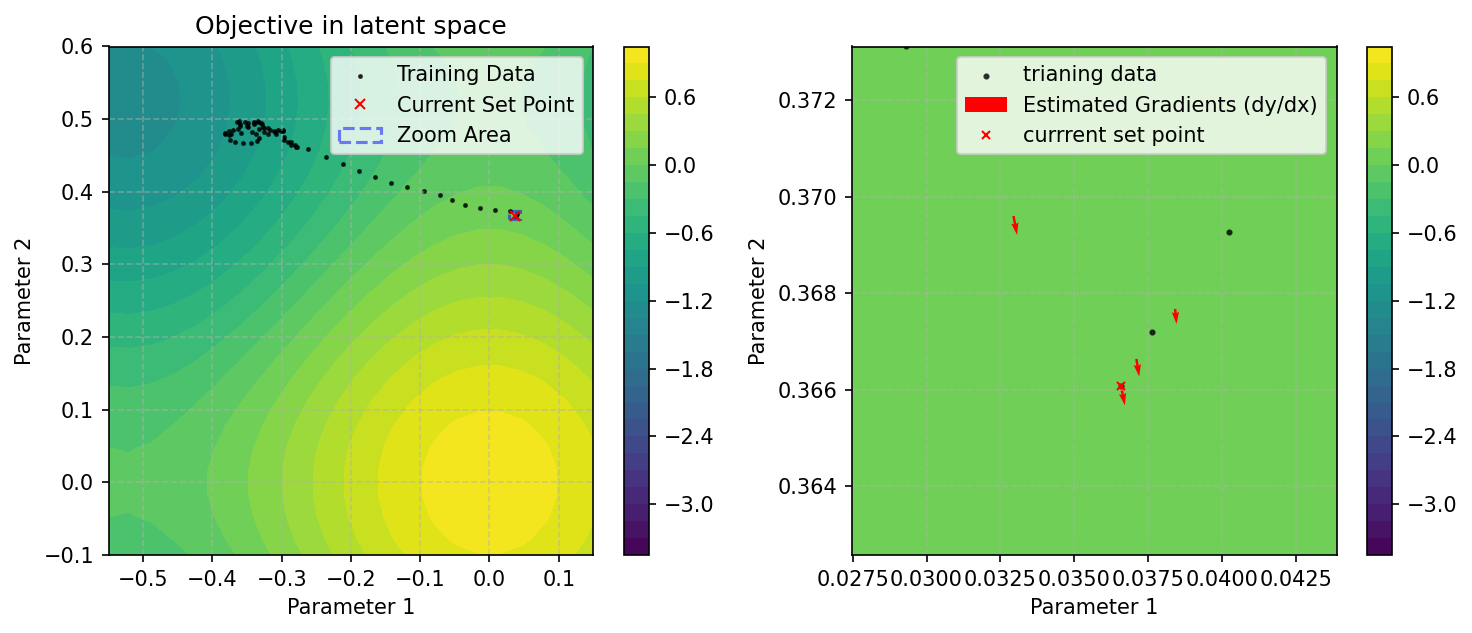

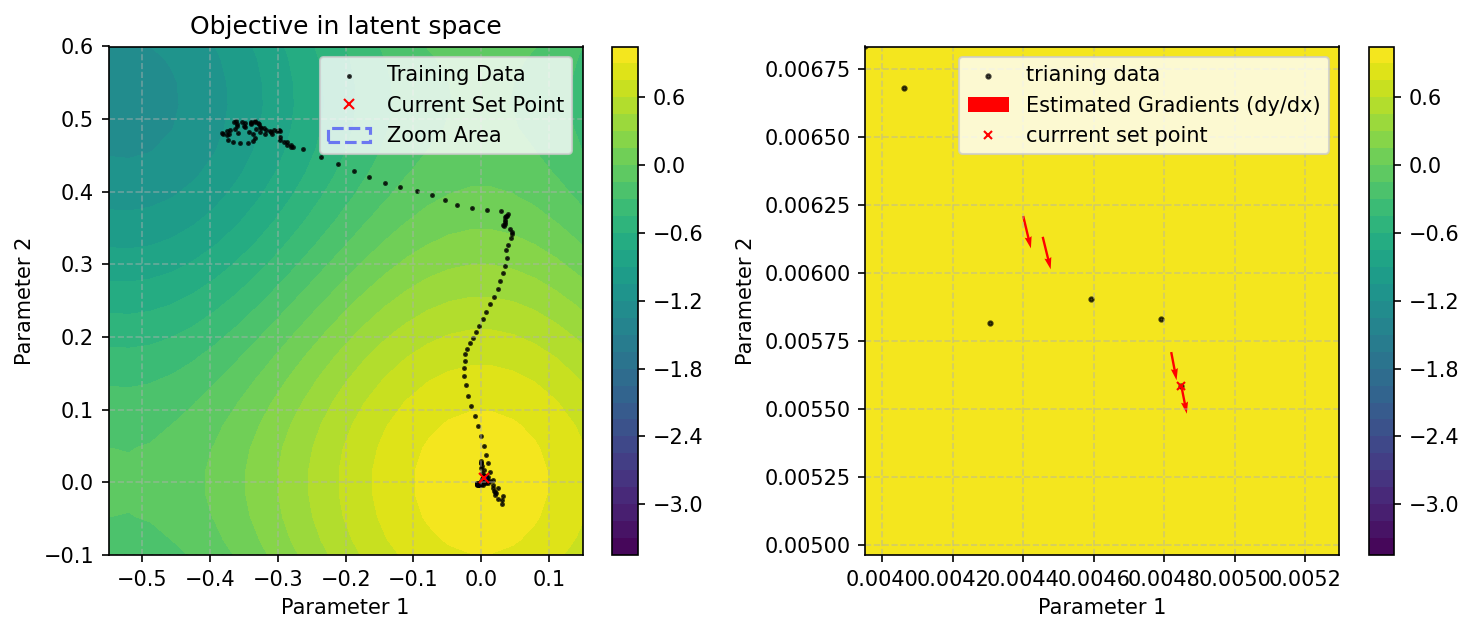

In [32]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)

# adamSG wo ES

In [33]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          model_train_budget = model_train_budget, optimizer=optimizer, asynchronous = asynchronous)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=0)

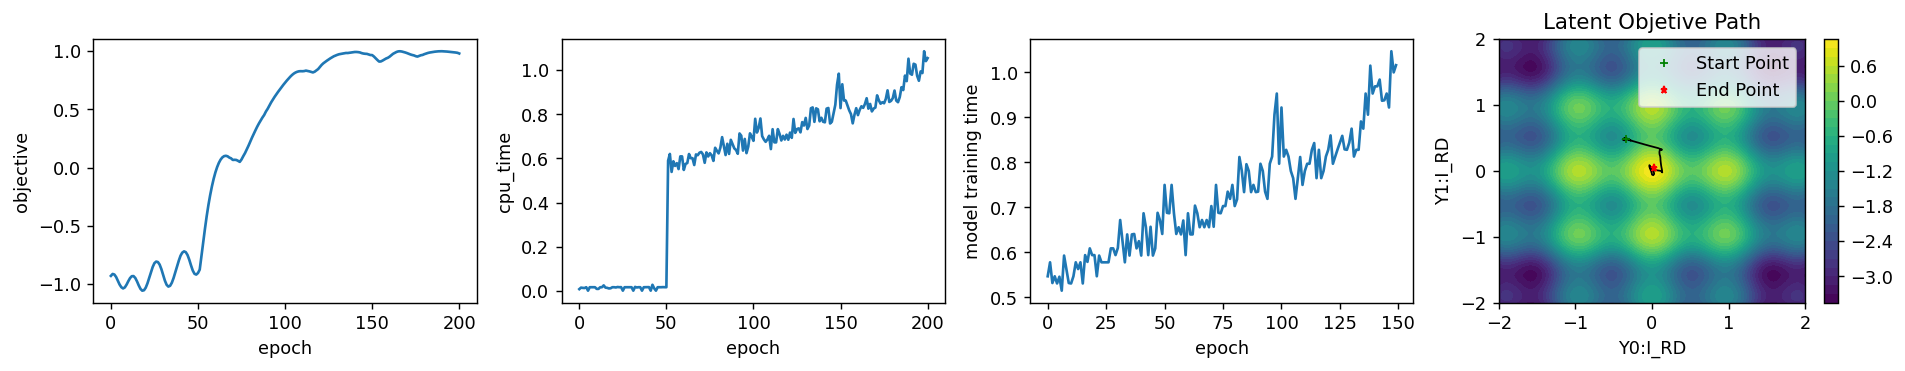

In [34]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

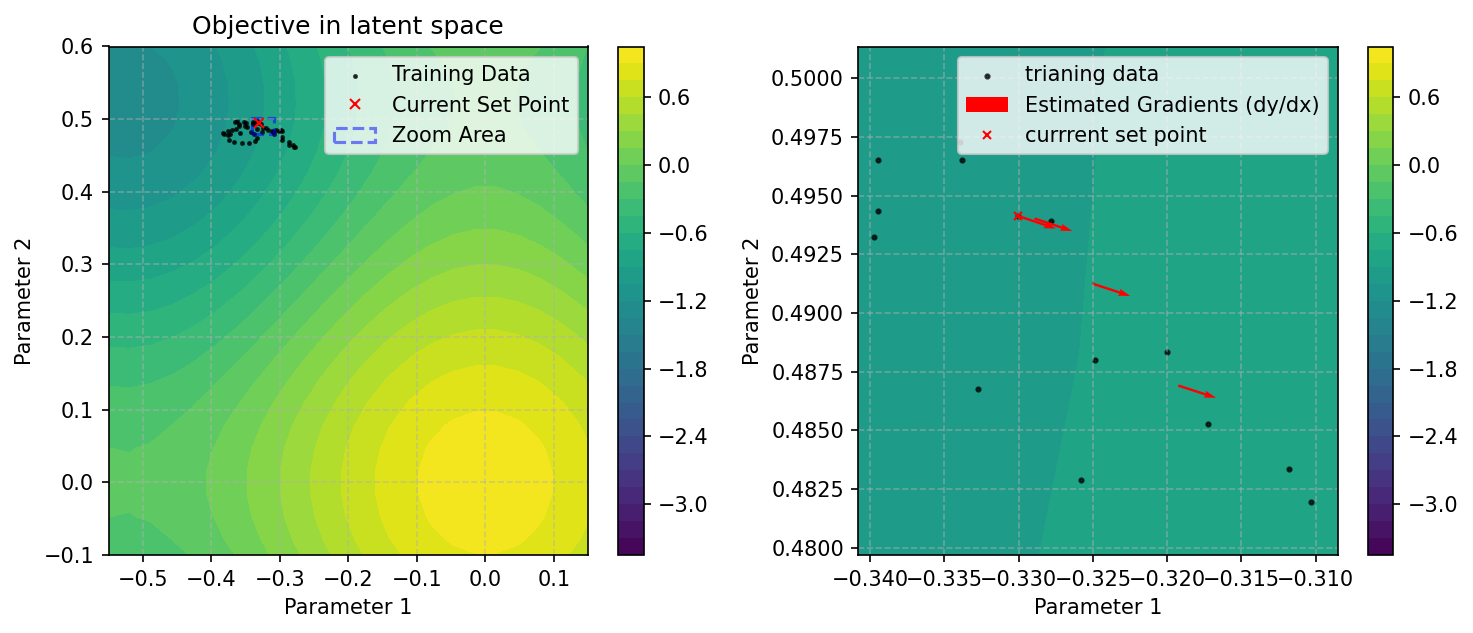

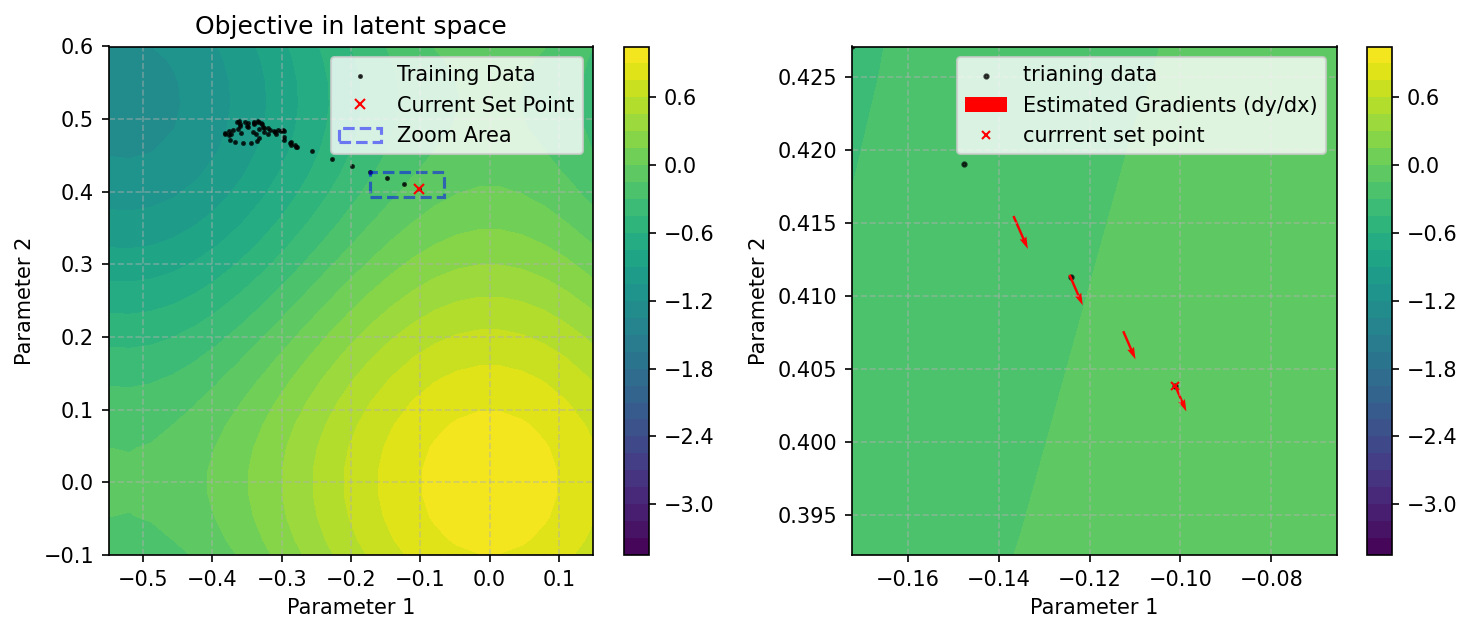

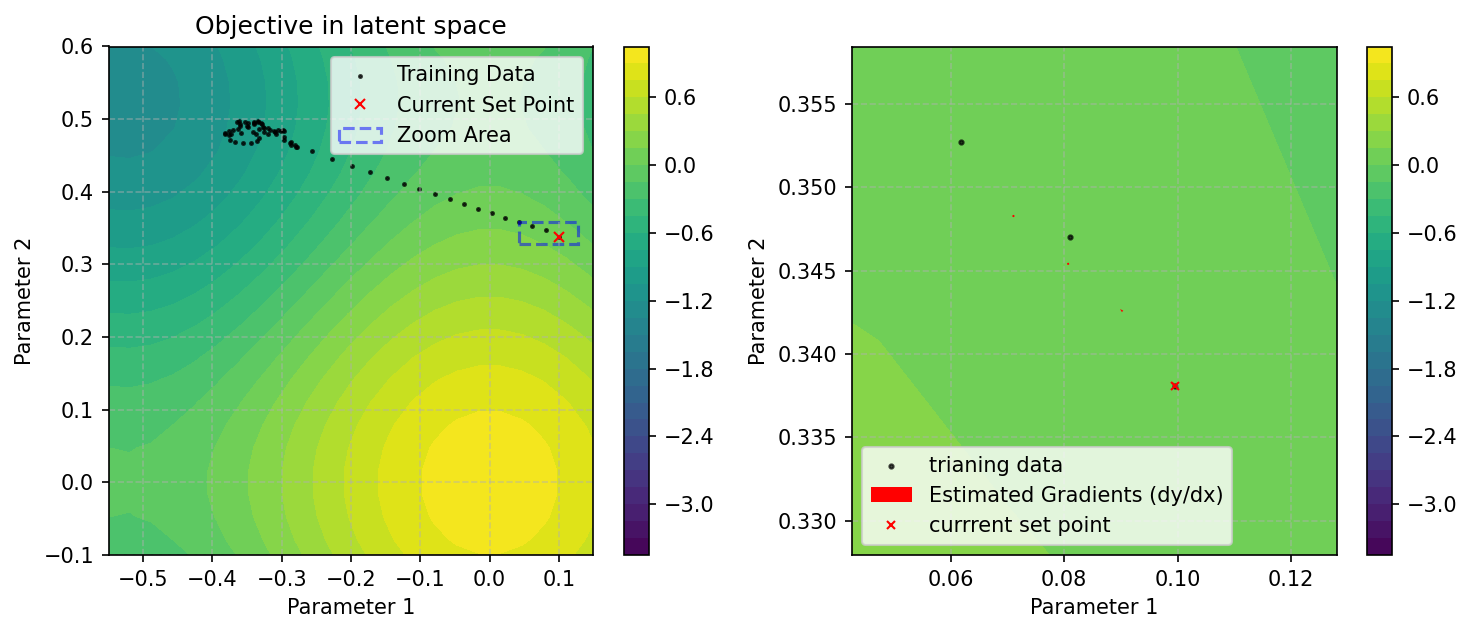

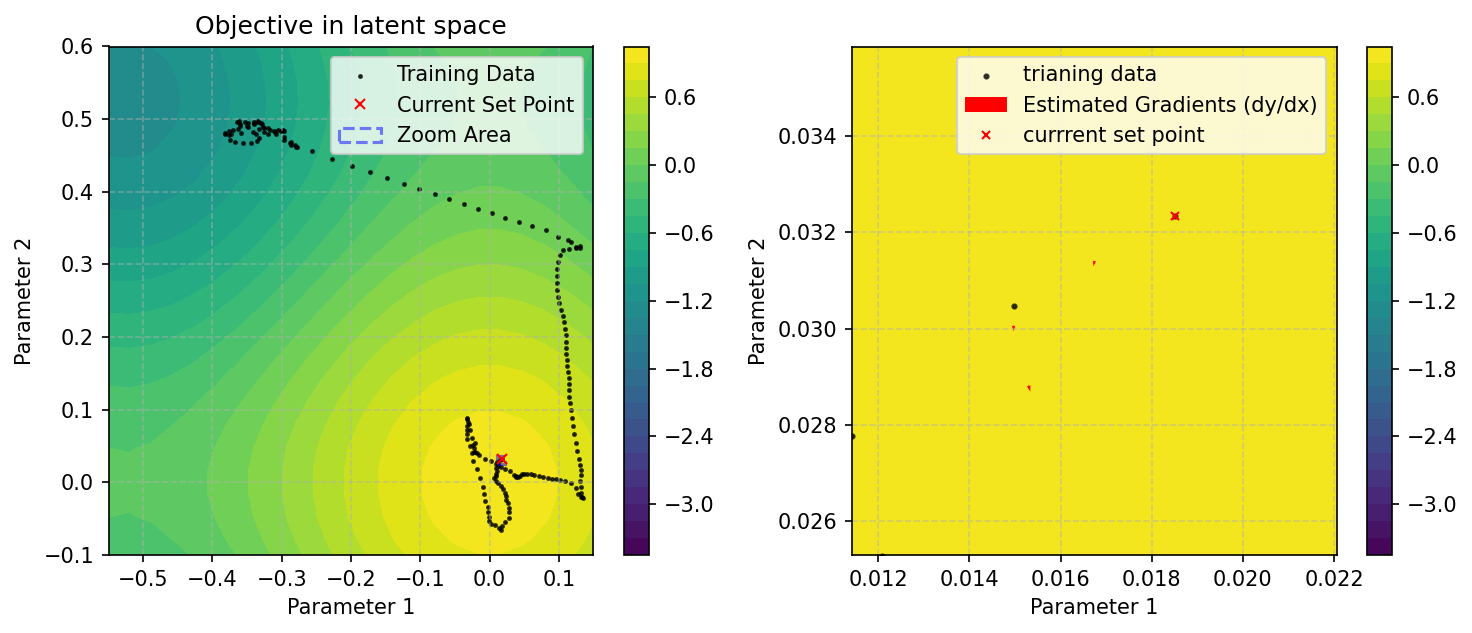

In [35]:
plot_grad(sv,epoch=50)
plot_grad(sv,epoch=60)
plot_grad(sv,epoch=70)
plot_grad(sv,epoch=budget)